# Welcome to LUSID!

In this tutorial we'll see how to use LUSID to perform the following task:

**<div align="center">As a UK asset manager, I run a single portfolio containing UK equities and investment grade vanilla bonds, and additionally maintain a cash position. The portfolio contains around 20 positions and trades around 5 positions a week. I want to view the asset allocation (equities vs bonds vs cash) on a daily basis.</div>**

In [1]:
# Set up LUSID
import os
import pandas as pd
import json
import uuid
import matplotlib.pyplot as plt
from IPython.core.display import HTML
import logging
logging.basicConfig(level = logging.INFO)

import lusid as lu
import lusid.api as la
import lusid.models as lm
import fbnsdkutilities.utilities as utils

from lusidjam import RefreshingToken
from lusidtools.pandas_utils.lusid_pandas import lusid_response_to_data_frame
from lusidtools.jupyter_tools import StopExecution
from lusidtools.lpt.lpt import to_date

# Set pandas display options
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.options.display.float_format = "{:,.2f}".format

# Authenticate to SDK
# Run the Notebook in Jupyterhub for your LUSID domain and authenticate automatically
secrets_path = os.getenv("FBN_SECRETS_PATH")
# Run the Notebook locally using a secrets file (see https://support.lusid.com/knowledgebase/article/KA-01663)
if secrets_path is None:
    secrets_path = os.path.join(os.path.dirname(os.getcwd()), "secrets.json")

api_factory = utils.ApiClientFactory(
    lu,
    token = RefreshingToken(), 
    api_secrets_filename = secrets_path,
    app_name = "LusidJupyterNotebook"
)

# Confirm success by printing SDK version
api_status = pd.DataFrame(api_factory.build(lu.ApplicationMetadataApi).get_lusid_versions().to_dict())
display(api_status)

,api_version,build_version,excel_version,links
0,v0,0.6.11270.0,0.5.3236,"{'relation': 'RequestLogs', 'href': 'http://fb..."


In [2]:
# Specify a unique scope and code to segregate data in this tutorial from others
module_scope = "FBNUniversity"
module_code = "Module-1"
print(f"'{module_scope}\{module_code}' scope and code created.")

'FBNUniversity\Module-1' scope and code created.


## 1. Populating the LUSID instrument master

We assume we have an `assets.csv` file exported from a securities database. We'll use this information to create valid instrument definitions for entities and bonds. Note LUSID is prepopulated with a basket of standard currencies, so we don't have to explicitly create the `GBP` currency instrument required to maintain our cash position. Note also we'll upload the instruments to a custom instrument scope, to segregate the data.

In [3]:
# Obtain the Instruments API
instruments_api=api_factory.build(la.InstrumentsApi)

# Read assets into pandas dataframe from securities file and show it
assets_df = pd.read_csv("data/assets.csv", keep_default_na = False)
display(assets_df)

,instrument_name,internal_id,currency,isin,figi,ticker,security_type,coupon,maturity_date
0,BP,imd_43535553,GBP,GB0007980591,BBG000C05BD1,BP/LN,equity,,
1,Burberry,imd_43599356,GBP,GB0031743007,BBG000NSXQ99,BRBY LN,equity,,
2,Croda International,imd_87289932,GBP,GB00BJFFLV09,BBG000BDCLS8,CRDA LN,equity,,
3,Experian,imd_34539955,GBP,GB00B19NLV48,BBG000FBCMD2,EXPN LN,equity,,
4,Halma,imd_78009283,GBP,GB0004052071,BBG000BDLT47,HLMA LN,equity,,
5,Glencore,imd_34534555,GBP,JE00B4T3BW64,BBG001MM1KV4,GLEN LN,equity,,
6,Just Eat Takeawy,imd_35436366,GBP,NL0012015705,BBG0065YWM39,JET LN,equity,,
7,Kingfisher,imd_34535552,GBP,GB0033195214,BBG000BKH1W6,KGF LN,equity,,
8,Mondi,imd_34567998,GBP,GB00B1CRLC47,BBG000PQKVN8,MNDI LN,equity,,
9,Next plc,imd_34569987,GBP,GB0032089863,BBG000BDWPY0,NXT LN,equity,,


In [4]:
# Create a dictionary of instrument definitions from asset data
definitions = {}

# Iterate over each row in the assets dataframe
for index, asset in assets_df.iterrows():
    
    # Map identifier columns to case-sensitive LUSID identifier names       
    identifiers = {
        # Unique identifiers
        "Figi": lm.InstrumentIdValue(value = asset["figi"]),
        "ClientInternal": lm.InstrumentIdValue(value = asset["internal_id"]),
        # Non-unique identifiers
        "Isin": lm.InstrumentIdValue(value = asset["isin"]),
        "Ticker": lm.InstrumentIdValue(value = asset["ticker"])  
    }
                                       
    # Model equities
    if asset["security_type"] == "equity":
        # Create definitions
        definitions[asset["instrument_name"]] = lm.InstrumentDefinition(
            name = asset["instrument_name"],
            identifiers = identifiers,
            definition = lm.Equity(
                instrument_type = "Equity",
                dom_ccy = asset["currency"],
                identifiers = {}
            )
        )
    # Model bonds
    elif asset["security_type"] == "govt bond":
        definitions[asset["instrument_name"]] = lm.InstrumentDefinition(
            name = asset["instrument_name"],
            identifiers = identifiers,
            definition = lm.Bond(
                instrument_type = "Bond",
                start_date = "2021-01-01",
                maturity_date = asset['maturity_date'],
                dom_ccy = asset["currency"],
                flow_conventions = lm.FlowConventions(
                    currency = asset["currency"],
                    payment_frequency = "6M",
                    day_count_convention = "ActualActual",
                    roll_convention = "NoAdjustment",
                    payment_calendars = [],
                    reset_calendars = [],
                    settle_days = 0,
                    reset_days = 0
                ),
                # Note that a bond instrument is unitised and the quantity specified in bond transactions
                principal = 1,
                # Specified as a number rather than percentage, eg. so a bond paying 0.375% is specified as 0.00375
                coupon_rate = asset["coupon"]
            )
        )
    
# Upsert instruments to a custom scope in LUSID
upsert_instruments_response = instruments_api.upsert_instruments(
    request_body = definitions, 
    scope = f"{module_scope}{module_code}",
)

# Transform API response to a dataframe and show internally-generated unique LUID for each mastered instrument
upsert_instruments_response_df = lusid_response_to_data_frame(list(upsert_instruments_response.values.values()))
display(upsert_instruments_response_df[["name", "lusid_instrument_id"]])

,name,lusid_instrument_id
0,Unilever,LUID_0001JQOT
1,RELX,LUID_0001JQP4
2,Croda International,LUID_0001JQP1
3,Tesco,LUID_0001JQP2
4,Experian,LUID_0001JQOU
5,Taylor Wimpey,LUID_0001JQOX
6,Kingfisher,LUID_0001JQOY
7,Burberry,LUID_0001JQOZ
8,WPP plc,LUID_0001JQP0
9,Glencore,LUID_0001JQON


## 2. Creating a portfolio

We'll backdate the portfolio a month to be certain every transaction we wish to load comes after. Note we also set the instrument scope of the portfolio to be the scope into which instruments were loaded.

In [5]:
# Obtain the Transaction Portfolios API
transaction_portfolios_api=api_factory.build(la.TransactionPortfoliosApi)

# Create portfolio definition
definition = lm.CreateTransactionPortfolioRequest(
    display_name = "Module 1",
    code = module_code,
    base_currency = "GBP",
    # Must be before first transaction recorded
    created = "2021-12-01",
    # Attempt to resolve transactions to instruments in the custom scope before falling back to the default scope
    instrument_scopes = [f"{module_scope}{module_code}"],
)

# Upsert portfolio to LUSID, making sure it's not already there
try:
    create_portfolio_response = transaction_portfolios_api.create_portfolio(
        scope = module_scope,
        create_transaction_portfolio_request = definition
    )
    # Confirm success
    print(f"Portfolio with display name '{create_portfolio_response.display_name}' created effective {str(create_portfolio_response.created)}")
except lu.ApiException as e:
    if json.loads(e.body)["name"] == "PortfolioWithIdAlreadyExists":
            logging.info(json.loads(e.body)["title"])
  

INFO:root:Could not create a portfolio with id 'Module-1' because it already exists in scope 'FBNUniversity'.


## 3. Setting initial positions

We *could* load a stream of transactions by calling the `UpsertTransactions` API, but here we're going to set positions explicitly using the `SetHoldings` API, using data sourced from a file. We'll date them as effective 1 January 2022.

`SetHoldings` creates an 'adjustment transaction' for each position in a portfolio that does not impact the portfolio's cash balance. Note that any transaction booked into LUSID must specify at least one instrument identifier that enables LUSID to resolve it to a mastered instrument. In this example, we'll use FIGIs.

In [6]:
# Obtain the Transaction Portfolios API (SetHoldings is an endpoint in this collection)
transaction_portfolios_api = api_factory.build(la.TransactionPortfoliosApi)

# Read initial equity and bond position data into dataframe from file and show it
positions_df = pd.read_csv('data/positions.csv')
# Create a virtual Cost column to multiply Quantity * Price for equities, and Price / Par * Quantity for bonds
positions_df["Cost"] = positions_df.apply(
    lambda row: (row["Quantity"] * row["Price"] if row["Class"] == "Equity" 
                 else row["Price"] / 100 * row["Quantity"]), axis = 1) 
display(positions_df)

,Asset,Class,Figi,Quantity,Price,Currency,Cost
0,BP,Equity,BBG000C05BD1,500,101,GBP,"50,500.00"
1,Burberry,Equity,BBG000NSXQ99,490,111,GBP,"54,390.00"
2,Croda,Equity,BBG000BDCLS8,480,116,GBP,"55,680.00"
3,Experian,Equity,BBG000FBCMD2,470,121,GBP,"56,870.00"
4,Halma,Equity,BBG000BDLT47,460,126,GBP,"57,960.00"
5,Glencore,Equity,BBG001MM1KV4,450,131,GBP,"58,950.00"
6,Just Eat,Equity,BBG0065YWM39,440,141,GBP,"62,040.00"
7,Kingfisher,Equity,BBG000BKH1W6,430,151,GBP,"64,930.00"
8,Mondi,Equity,BBG000PQKVN8,420,161,GBP,"67,620.00"
9,Next,Equity,BBG000BDWPY0,410,165,GBP,"67,650.00"


In [7]:
# Iterate over equities and bonds in the positions file, creating one adjustment transaction per row
holdings = [
    lm.AdjustHoldingRequest(
        # Resolve to mastered instruments using FIGI identifiers
        instrument_identifiers = {"Instrument/default/Figi": position["Figi"]},
        tax_lots = [
            lm.TargetTaxLotRequest(
                units = position["Quantity"],
                cost = lm.CurrencyAndAmount(
                    amount = position["Cost"],
                    currency = position["Currency"]
                ),
                portfolio_cost = position["Cost"],
                price = position["Price"])
        ]
    )
    for index, position in positions_df.iterrows()
]

# Create an initial cash position by hand
holdings.append(
    lm.AdjustHoldingRequest(
        # Resolve to GBP currency instrument prepopulated in LUSID
        instrument_identifiers = {"Instrument/default/Currency": "GBP"},
        tax_lots = [
            lm.TargetTaxLotRequest(
                units = 50000,
                cost = lm.CurrencyAndAmount(
                    amount = 50000,
                    currency = "GBP"
                ),
                price = 100
            )
        ]
    )
)

# Set holdings in LUSID
set_holdings_response = transaction_portfolios_api.set_holdings(
    scope = module_scope,
    code = module_code,
    # Make transactions effective from start of year
    effective_at = "2022-01-01",
    adjust_holding_request = holdings
)
print(f'{positions_df.shape[0]} equity/bond positions, plus cash, loaded into {module_scope}/{module_code} portfolio')

20 equity/bond positions, plus cash, loaded into FBNUniversity/Module-1 portfolio


## 4. Calculating holdings

Now we can ask LUSID to calculate our official positions. For a portfolio containing a stream of transactions, LUSID automatically calculates instrument and cash positions from the stream of buys and sells. It also takes into account other economic activity, for example stock splits or dividends resulting from corporate actions.

Since we set our initial positions explicitly and no activity has occurred since, our holdings will be the same.

In [8]:
# Obtain the Transaction Portfolios API (GetHoldings is an endpoint in this collection)
transaction_portfolios_api = api_factory.build(la.TransactionPortfoliosApi)

# Get holdings for portfolio
get_holdings_response = transaction_portfolios_api.get_holdings(
    scope = module_scope, 
    code = module_code,
    # Decorate on instrument name property for clarity
    property_keys = ["Instrument/default/Name"]
)
# Transform API response to a pandas dataframe and show it
get_holdings_response_df = lusid_response_to_data_frame(get_holdings_response, rename_properties = True)
# Drop some noisy columns
get_holdings_response_df.drop(columns = [
    "instrument_scope", "sub_holding_keys", "cost_portfolio_ccy.currency", "currency", "SourcePortfolioId(default-Properties)", "SourcePortfolioScope(default-Properties)"], inplace = True)
display(get_holdings_response_df)

,instrument_uid,Name(default-Properties),holding_type,units,settled_units,cost.amount,cost.currency,cost_portfolio_ccy.amount,holding_type_name
0,LUID_0001JQOR,BP,P,500.00,500.00,"50,500.00",GBP,"50,500.00",Position
1,LUID_0001JQOZ,Burberry,P,490.00,490.00,"54,390.00",GBP,"54,390.00",Position
2,LUID_0001JQP1,Croda International,P,480.00,480.00,"55,680.00",GBP,"55,680.00",Position
3,LUID_0001JQOU,Experian,P,470.00,470.00,"56,870.00",GBP,"56,870.00",Position
4,LUID_0001JQP3,Halma,P,460.00,460.00,"57,960.00",GBP,"57,960.00",Position
5,LUID_0001JQON,Glencore,P,450.00,450.00,"58,950.00",GBP,"58,950.00",Position
6,LUID_0001JQOW,Just Eat Takeawy,P,440.00,440.00,"62,040.00",GBP,"62,040.00",Position
7,LUID_0001JQOY,Kingfisher,P,430.00,430.00,"64,930.00",GBP,"64,930.00",Position
8,LUID_0001JQP6,Mondi,P,420.00,420.00,"67,620.00",GBP,"67,620.00",Position
9,LUID_0001JQOP,Next plc,P,410.00,410.00,"67,650.00",GBP,"67,650.00",Position


## 5. Setting up valuation

### 5.1 Creating a recipe

Before we can value the portfolio, we need to create a recipe that tells LUSID where to find market data and which pricing model and methodology to use.

We'll be storing market data (prices) in the LUSID quote store later.

In [9]:
# Obtain the Configuration Recipe API (note this is currently only available in the LUSID Python Preview SDK)
recipe_api = api_factory.build(la.ConfigurationRecipeApi)

# Create recipe definition
recipe = lm.ConfigurationRecipe(
    # Put the recipe in the same scope as the portfolio
    scope = module_scope,
    # Give the recipe a unique code in the scope
    code = f"{module_code}Recipe",
    description = "A recipe to value a portfolio containing equities and bonds",
    market = lm.MarketContext(
        market_rules = [
            # Look up pricing data for equities and bonds
            lm.MarketDataKeyRule(
                # Look up prices loaded into the quote store using FIGI identifiers
                key = "Quote.Figi.*",
                supplier = "Lusid",
                data_scope = module_scope,
                quote_type = "Price",
                field = "mid",
                # Allow quotes to be valid for 2 years
                quote_interval = "2Y"
            ),
        ],
    ),
    pricing = lm.PricingContext(
        # Force the SimpleStatic pricing model on bonds (this is already the default for equities).
        # Otherwise, bonds will be discounted.
        model_rules = [
            lm.VendorModelRule(
                supplier = "Lusid",
                model_name = "SimpleStatic",
                instrument_type = "Bond"
            )
        ],
    )
)

# Upsert recipe to LUSID
upsert_recipe_response = (recipe_api.upsert_configuration_recipe(
        upsert_recipe_request = lm.UpsertRecipeRequest(
            configuration_recipe = recipe
        )
    )
)
print(f"Recipe upserted at {upsert_recipe_response.value}")

Recipe upserted at 2023-05-09 14:23:07.553345+00:00


### 5.2 Specifying aggregation rules

We'll create a convenience function to call each time we want to value our portfolio that enables us to group assets in different ways. The function identifies the recipe to use and aggregates results by a set of metrics that present useful information.

In [10]:
# Obtain the Aggregation API (note this is currently only available in the LUSID Python Preview SDK)
aggregation_api = api_factory.build(la.AggregationApi)

# Create convenience valuation function
def perform_valuation(date, group_by):
    # Create valuation request
    valuation_request = lm.ValuationRequest(
        # Choose recipe to use
        recipe_id = lm.ResourceId(scope = module_scope, code = f"{module_code}Recipe"),
        # Specify metrics (also known as queryable keys) to report useful information
        metrics = [
            lm.AggregateSpec("Instrument/default/Name", "Value"),
            lm.AggregateSpec("Instrument/AssetClass", "Value"),
            lm.AggregateSpec("Quotes/Price", "Value"),
            lm.AggregateSpec("Holding/default/Units", "Value"),
            lm.AggregateSpec("Holding/default/Cost", "Sum"),
            lm.AggregateSpec("Valuation/PV/Amount", "Sum"),
            lm.AggregateSpec("Valuation/PV/Amount", "Proportion"),
            lm.AggregateSpec("Holding/default/Accrual", "Sum"),
        ],
        # Make grouping of results conditional on queryable key passed into function
        group_by = [group_by],
        # Identify portfolio to value
        portfolio_entity_ids = [lm.PortfolioEntityId(scope = module_scope, code = module_code)],
        # Make date of valuation conditional on effective at date passed into function
        valuation_schedule = lm.ValuationSchedule(effective_at = date),
    )
    
    # Get portfolio valuation
    val_data = aggregation_api.get_valuation(valuation_request = valuation_request).data
    
    # Turn valuation response into pandas dataframe
    vals_df = pd.DataFrame(val_data)
    # Turn valuation proportions into percentages
    vals_df["Proportion(Valuation/PV/Amount)"] = vals_df["Proportion(Valuation/PV/Amount)"] * 100
    # Give columns friendlier names
    vals_df.rename(
        columns = {
            "Instrument/default/Name": "Instrument",
            "Instrument/AssetClass": "Asset Class",
            "Sum(Valuation/PV/Amount)": "Present Value",
            "Proportion(Valuation/PV/Amount)": "% Portfolio",
            "Quotes/Price": "Price",
            "Holding/default/Units": "Units",
            "Sum(Holding/default/Cost)": "Cost",
            "Sum(Holding/default/Accrual)": "Interest Accrued"
        },
        inplace = True,
    )
    try:
        return vals_df.drop("Aggregation/Errors", axis=1)
    
    except:
        return vals_df

## 6. Valuing the portfolio on 1 January 2022

We created our portfolio and set initial positions effective from 1 January 2022. Let's value the portfolio at the end of that day.

### 6.1 Loading market data

The recipe requires market data (prices) and expects to find it in the LUSID quote store. The first task is therefore to load closing market prices for 1 January 2022.

In [11]:
# Obtain the Quotes API
quotes_api = api_factory.build(la.QuotesApi)

# Load prices from market data vendor file
prices_df = pd.read_csv("data/prices.csv")
# Create a virtual Scale Factor column to enable valuation to scale properly: 1 for equities, par value for bonds
prices_df["Scale Factor"] = prices_df["Class"].apply(lambda x: 1 if x == "Equity" else 100) 
display(prices_df)

,Asset,Class,Figi,Date,Price,Currency,Scale Factor
0,BP,Equity,BBG000C05BD1,01/01/2022,101.50,GBP,1
1,Burberry,Equity,BBG000NSXQ99,01/01/2022,110.80,GBP,1
2,Croda,Equity,BBG000BDCLS8,01/01/2022,116.10,GBP,1
3,Experian,Equity,BBG000FBCMD2,01/01/2022,119.10,GBP,1
4,Halma,Equity,BBG000BDLT47,01/01/2022,131.50,GBP,1
5,Glencore,Equity,BBG001MM1KV4,01/01/2022,132.60,GBP,1
6,Just Eat,Equity,BBG0065YWM39,01/01/2022,156.30,GBP,1
7,Kingfisher,Equity,BBG000BKH1W6,01/01/2022,149.70,GBP,1
8,Mondi,Equity,BBG000PQKVN8,01/01/2022,156.70,GBP,1
9,Next,Equity,BBG000BDWPY0,01/01/2022,168.60,GBP,1


In [12]:
# Iterate over prices in the dataframe, creating one quote definition per row
quotes = {
    # Each quote must be upserted with an ephemeral key (uuid in this case), to track errors in the response
    str(uuid.uuid4()): lm.UpsertQuoteRequest(
        quote_id = lm.QuoteId(
            quote_series_id = lm.QuoteSeriesId(
                provider = "Lusid",
                instrument_id = price["Figi"],
                instrument_id_type = "Figi",
                quote_type = "Price",
                # Case sensitive: the field value must match that of the equivalent recipe field value exactly
                field = "mid",
            ),
            effective_at = to_date(price["Date"]).isoformat(),
        ),
        metric_value = lm.MetricValue(value = price["Price"], unit = price["Currency"]),
        # Bonds require a scale factor of 100
        scale_factor = price["Scale Factor"]
    )
    for row, price in prices_df.iterrows()
}

# Upsert quotes into LUSID
upsert_quotes_response = quotes_api.upsert_quotes(scope = module_scope, request_body = quotes)

if upsert_quotes_response.failed == {}:
    print(f"{len(upsert_quotes_response.values)} quotes successfully loaded into LUSID.")

else:
    print(f"Some failures occurred. {len(upsert_quotes_response.failed)} did not get loaded into LUSID.")

20 quotes successfully loaded into LUSID.


### 6.2 Valuing assets individually

To value each asset individually, we ask LUSID to group results by instrument name. Note that bonds are in the 'Credit' asset class.

In [13]:
# Call our valuation function for close of day 1 Jan 2022, passing in the appropriate queryable key
valuation_df = perform_valuation("2022-01-01T17:00:00Z", "Instrument/default/Name")
display(valuation_df)

,Present Value,% Portfolio,Instrument,Asset Class,Price,Units,Cost,Interest Accrued
0,"50,750.00",3.64,BP,Equities,101.50,500.00,"50,500.00",0.00
1,"54,292.00",3.89,Burberry,Equities,110.80,490.00,"54,390.00",0.00
2,"55,728.00",4.00,Croda International,Equities,116.10,480.00,"55,680.00",0.00
3,"55,977.00",4.01,Experian,Equities,119.10,470.00,"56,870.00",0.00
4,"60,490.00",4.34,Halma,Equities,131.50,460.00,"57,960.00",0.00
5,"59,670.00",4.28,Glencore,Equities,132.60,450.00,"58,950.00",0.00
6,"68,772.00",4.93,Just Eat Takeawy,Equities,156.30,440.00,"62,040.00",0.00
7,"64,371.00",4.62,Kingfisher,Equities,149.70,430.00,"64,930.00",0.00
8,"65,814.00",4.72,Mondi,Equities,156.70,420.00,"67,620.00",0.00
9,"69,126.00",4.96,Next plc,Equities,168.60,410.00,"67,650.00",0.00


### 6.3 Valuing by asset class

To aggregate up to equities vs bonds vs cash, we ask LUSID to group results by asset class.

In [14]:
# Call our valuation function for close of day 1 Jan 2022, passing in the appropriate queryable key
valuation_df = perform_valuation("2022-01-01T17:00:00Z", "Instrument/AssetClass")
display(valuation_df)

,Present Value,% Portfolio,Instrument,Asset Class,Price,Units,Cost,Interest Accrued
0,"1,109,018.00",79.54,None,Equities,None,NaN,"1,098,280.00",0.00
1,"235,358.39",16.88,None,Credit,None,NaN,"232,100.00",418.39
2,"50,000.00",3.59,GBP,Money,None,"50,000.00","50,000.00",0.00


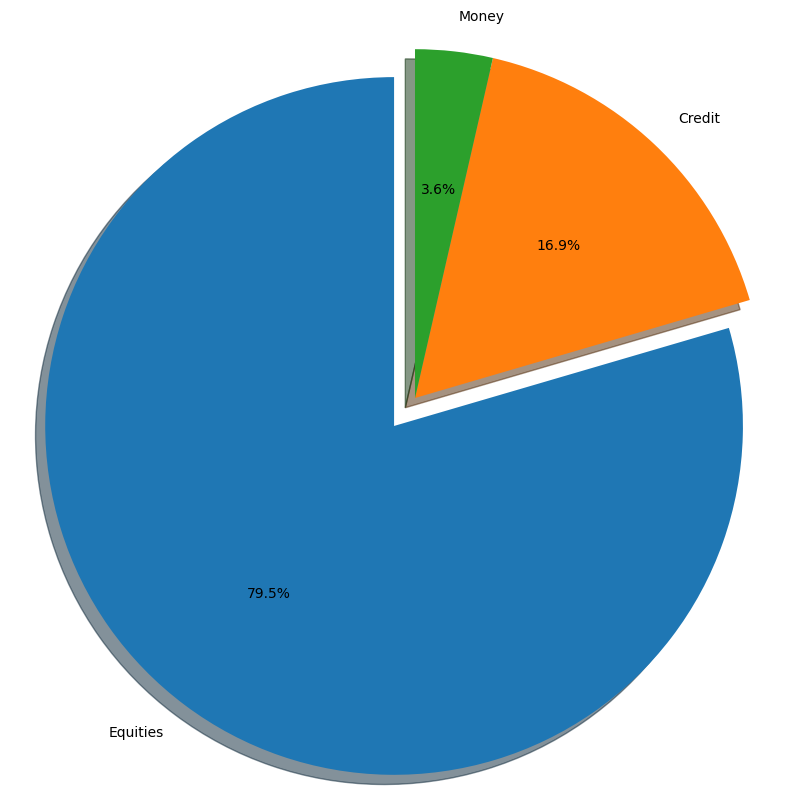

In [15]:
# Create pie chart    
labels = [row["Asset Class"] for index, row in valuation_df.iterrows()]
values = [row["% Portfolio"] for index, row in valuation_df.iterrows()]
explode = [0] * len(labels)
index = labels.index("Equities")
explode[index] = 0.1
fig1, ax1 = plt.subplots(figsize = (10,10))
ax1.pie(values, explode = explode, labels = labels, autopct = '%1.1f%%', shadow = True, startangle = 90)
ax1.axis('equal')
plt.show()